# High Value Customer Identification (Insiders)

# 0.0 Planejamento da Solução (IOT)

## Input (Entrada)

**1. Problema de Negócio**
* Selecionar os clientes mais valiosos para integrar um programa de fidelização.

**2. Conjunto de Dados**
* Vendas de um e-commerce online, durante o período de um ano (Nov 2015 - Dez 2017)

## Output (Saída)

**1. A indicação das pessoas que farão parte do programa de fidelização**
* Lista: com client_id | is_insider

**2. Relatório com as respostas para as perguntas de negócio**
* Quem são as pessoas elegíveis para participar do programa de Insiders?
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento, vida dos Insiders?
* Qual a expectativa de faturamento desse grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
* Quais as condições para uma pessoa ser removida dos Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de Marketing pode tomar para aumentar o faturamento?

## Tasks (Tarefas)

**1. Quem são as pessoas elegíveis para participar do programa de Insiders?**

O que é ser elegível?

O que são clientes de maior "valor"?
- Faturamento
    * Alto ticket médio
    * Alto LTV (LifeTime Value)
    * Baixa Recência
    * Alto Basket size
    * Baixa probabilidade de Churn
    * Previsão de LTV
    * Alta propensão de compra
- Custo
    * Baixa taxa de devolução
- Experiência de compra
    * Média alta das avaliações

**2. Quantos clientes farão parte do grupo?**
- Número total de clientes
- % do grupo Insiders

**3. Quais as principais características desses clientes?**

* Escrever características dos clientes
    - Idade
    - Localização
* Escrever características do hábito de consumo
* Atributos da clusterização

**4. Qual a porcentagem de contribuição do faturamento, vida dos Insiders?**

* Faturamento total do ano
* Faturamento do grupo Insiders

**5. Qual a expectativa de faturamento desse grupo para os próximos meses?**

* LTV do grupo Insiders
* Análise de Cohort

**6. Quais as condições para uma pessoa ser elegível ao Insiders?**

* Definir a periodicidade
* A pesso precisa ser disimilar com uma pessoa do grupo

**7. Quais as condições para uma pessoa ser removida dos Insiders?**

* Definir a periodicidade
* A pesso precisa ser similar/parecida com uma pessoa do grupo

**8. Qual a garantia que o programa Insiders é melhor que o restante da base?**
* Teste A/B
* Teste A/B Bayesiano
* Teste de Hipóteses

**9. Quais ações o time de Marketing pode tomar para aumentar o faturamento?**
* Desconto
* Preferência de compra
* Frete
* Visita a empresa

## Benchamarking de soluções

### 1. Desk Research

**RFM Model**

_Recency_
* Tempo desde a última compra
* Responsividade

_Frequency_
* Tempo médio entre as transações
* Engajamento

_Monetary_
* Total gasto, faturamento
* "High-Value Purchases"

Modelo muito tradicional para empresas que tem CRM (Customer Relationship Management)

# 0.0 Imports

In [39]:
import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib          import pyplot as plt
from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer

from sklearn import cluster as c

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [23]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [4]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
data_raw = data_raw.drop(columns=['Unnamed: 8'])

In [6]:
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = data_raw

## 1.1 Rename columns

In [8]:
# Columns names in snake case
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']

# Renaming columns
df1.columns = cols_new

## 1.2 Data dimensions

In [9]:
# Information about shape
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 541909
Number of columns: 8


## 1.3 Data types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [11]:
# Sum of null values
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [12]:
# Removing null values for initial analysis
df1 = df1.dropna(subset=['description', 'customer_id'])
print(f'Removed data: {1-(df1.shape[0]/data_raw.shape[0]):.2f}')

Removed data: 0.25


## 1.6 Change dtypes

In [13]:
# Changing date time
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# Changing customer id to integer
df1['customer_id'] = df1['customer_id'].astype(int)

/tmp/ipykernel_21511/2300041256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
/tmp/ipykernel_21511/2300041256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['customer_id'] = df1['customer_id'].astype(int)


## 1.7 Descripte Statistics

Skipped in initial analysis

# 2.0 FEATURE ENGINEERING

In [30]:
df2 = df1.copy()

In [31]:
# Creating a dataframe with unique customer ids
df_ref = pd.DataFrame({'customer_id': df2['customer_id']}).drop_duplicates(ignore_index=True)

# Creating RFM features
# Gross Revenue (quantity * unity price)
df2['gross_revenue'] = df2['quantity']*df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Merging dataframes
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last Day Purchase for each customer
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# Calculating number of days since last purchase
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

# Merging dataframes
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
# Creating dataframe with number of purchases for each customer
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

In [32]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


# 3.0 FILTRAGEM DAS VARIÁVEIS

Skipped in initial analysis

Skipped in initial analysis

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

Skipped in initial analysis

# 5.0 DATA PREPARATION

Skipped in initial analysis

# 6.0 FEATURE SELECTION

Skipped in initial analysis

# 7.0 HYPERPARAMETER FINE-TUNNING 

In [33]:
df7 = df_ref.drop(columns=['customer_id'])

In [34]:
clusters = [2, 3, 4, 5, 6]

## 7.1 Within-Cluster Sum of Square (WSS)

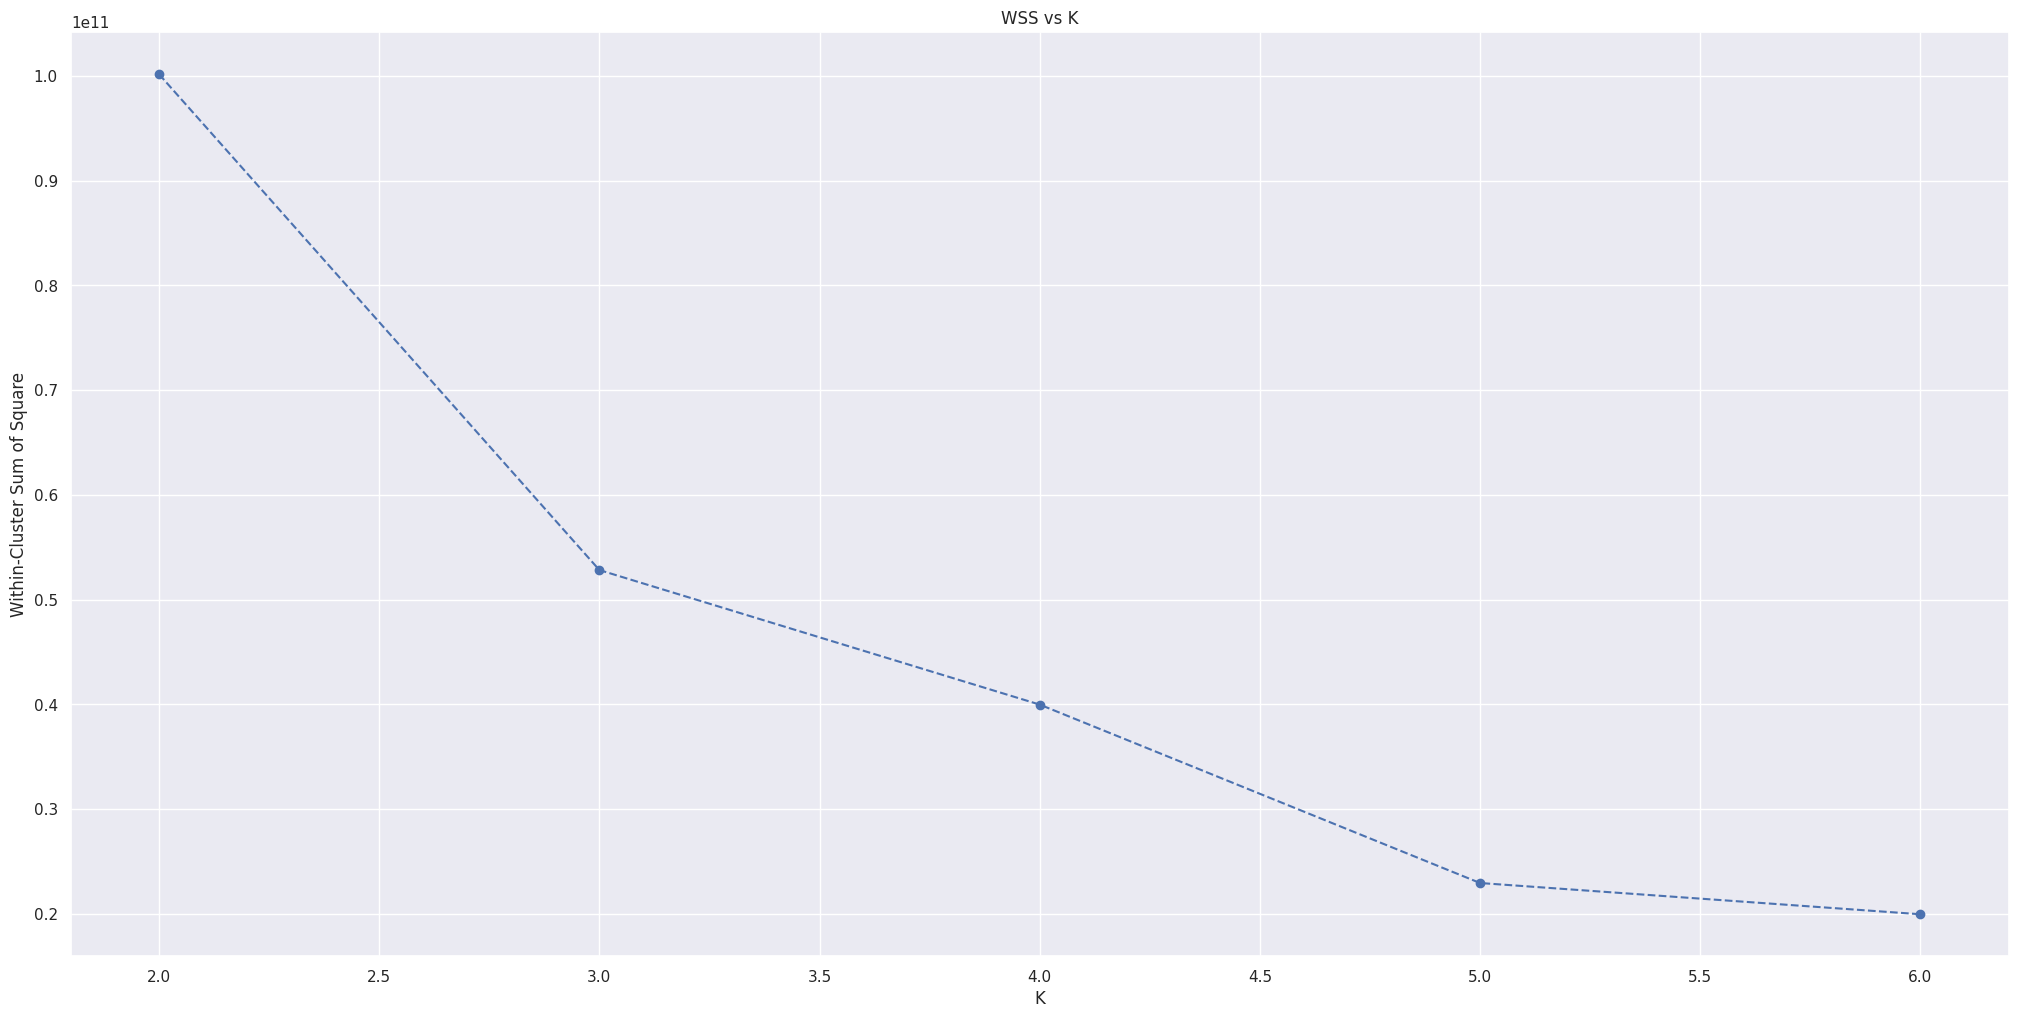

In [36]:
wss = []
for k in clusters:
    # Model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # Model training
    kmeans.fit(df7)
    
    # Validation
    wss.append(kmeans.inertia_)
    
# Ploting wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K');

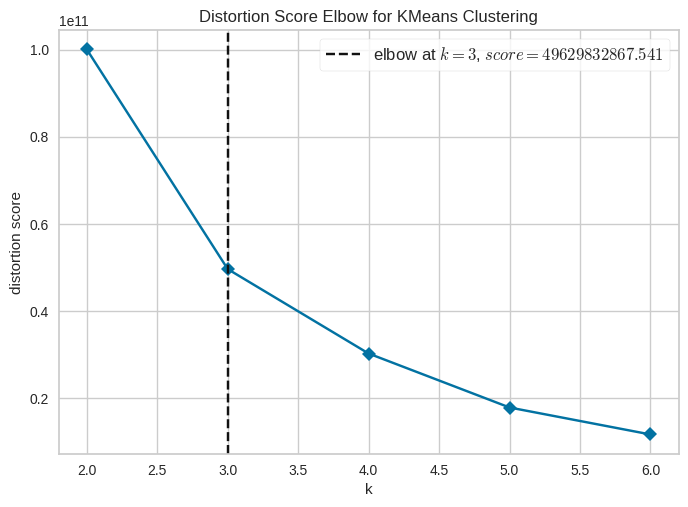

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
# Using Yellowbrick Visualizer
# Model definition
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, timings=False)

# Model training
kmeans.fit(df7)
kmeans.show()

## 7.2 Silhouette Score

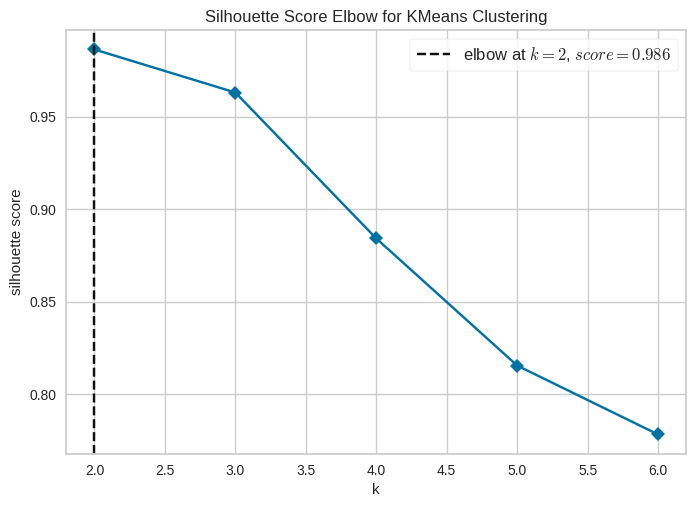

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [43]:
# Using Yellowbrick Visualizer
# Model definition
kmeans = KElbowVisualizer(c.KMeans(n_init=10), metric='silhouette', k=clusters, timings=False)

# Model training
kmeans.fit(df7)
kmeans.show()

# 8.0 MODEL TRAINING

# 9.0 CLUSTER ANALYSIS

# 10.0 DEPLOY TO PRODUCTION